In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/rtl.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))

# فصل ۴ — مبانی یادگیری نظارت‌شده
## درس ۶: بده‌بستان بایاس–واریانس و پیچیدگی مدل


### در این نوت‌بوک چه یاد می‌گیرید؟

در پایان این درس باید بتوانید:

- مفهوم **تعمیم‌پذیری (Generalization)** را توضیح دهید و بدانید چرا مدلی که روی دادهٔ آموزش عالی است ممکن است روی دادهٔ جدید شکست بخورد.
- **بایاس (Bias)**، **واریانس (Variance)** و **نویزِ کاهش‌ناپذیر (Irreducible Noise)** را تعریف کنید و ارتباط آن‌ها را با پیچیدگی مدل توضیح دهید.
- با استفاده از منحنی‌های یادگیری و اعتبارسنجی، علائم رایج **بایاس زیاد** در برابر **واریانس زیاد** را تشخیص دهید.
- با ابزارهای عملی (اعتبارسنجی متقاطع، منظم‌سازی، کنترل درجه/عمق، و تجمیع/Ensembling) بده‌بستان بایاس–واریانس را مدیریت کنید.
- در پایتون آزمایش‌هایی اجرا کنید که این بده‌بستان را هم در **رگرسیون** و هم در **طبقه‌بندی** به‌صورت ملموس نشان می‌دهد.

این درس عمداً عملی طراحی شده است: چندین مدل با پیچیدگی‌های مختلف می‌سازیم و می‌سنجیم که **خطای آموزش** و **خطای اعتبارسنجی/آزمون** چگونه تغییر می‌کنند. همچنین با تکرار نمونه‌گیری، “واریانس” را به‌طور مستقیم‌تر مشاهده می‌کنیم.

---

### ایدهٔ کلیدی (در یک جمله)

یک مدل می‌تواند «بیش از حد ساده» باشد (بایاس زیاد) یا «بیش از حد منعطف» (واریانس زیاد)؛ **تعمیم‌پذیری خوب** یعنی انتخاب پیچیدگی‌ای که خطای مورد انتظار روی دادهٔ جدید را کمینه کند.

---

### نمادگذاری و چارچوب

دادهٔ $(x_i, y_i)$ را از یک فرآیند ناشناخته مشاهده می‌کنیم. یک پیش‌بین $\hat{f}(x)$ را از مجموعه‌دادهٔ $D$ یاد می‌گیریم و روی دادهٔ دیده‌نشده ارزیابی می‌کنیم.

برای رگرسیون با زیانِ مربعی، یک تجزیهٔ معروف در نقطهٔ $x$ چنین است:

$$
\mathbb{E}\left[(Y - \hat{f}_D(x))^2\right] = \underbrace{\left(\mathbb{E}[\hat{f}_D(x)] - f(x)\right)^2}_{\text{Bias}^2}
+ \underbrace{\mathbb{V}[\hat{f}_D(x)]}_{\text{Variance}}
+ \underbrace{\mathbb{V}[\varepsilon]}_{\text{Noise}}
$$

که در آن $Y = f(x) + \varepsilon$ و $\varepsilon$ بیانگر تصادفی‌بودنی است که از روی $x$ قابل پیش‌بینی نیست (خطای اندازه‌گیری، متغیرهای حذف‌شده، ذاتاً تصادفی بودن پدیده و غیره).

نکات مهم:

- این تجزیه برای **زیان مربعی** در رگرسیون شفاف‌تر است. در طبقه‌بندی با زیان 0‑1، تحلیل مشابه است ولی تجزیهٔ بسته و ساده‌ای وجود ندارد؛ با این حال “بایاس/واریانس” هنوز یک **ابزار مفهومی برای عیب‌یابی** است.
- “Bias” در اینجا به معنی سوگیری اجتماعی نیست؛ منظور **خطای سیستماتیک** ناشی از فرض‌های مدل است.
- “پیچیدگی مدل” یک عدد یکتا نیست؛ معمولاً آن را با **ابرپارامترها** کنترل می‌کنیم (درجهٔ چندجمله‌ای، عمق درخت، $k$ در kNN، شدت منظم‌سازی و غیره).

---



### مدل ذهنی: پیچیدگی در برابر خطا

شکل زیر یک تصویر مفهومی ساده است. با افزایش پیچیدگی، معمولاً **خطای آموزش** به‌صورت یکنواخت کاهش می‌یابد، اما **خطای اعتبارسنجی/آزمون** اغلب شکل U پیدا می‌کند (ابتدا کاهش و سپس افزایش). نقطهٔ کمینه همان جایی است که معمولاً باید کار کنید.

```mermaid
flowchart LR
  A[Increase model complexity] --> B[Training error ↓]
  A --> C{Generalization error?}
  C -->|Too simple| D[High bias: underfit]
  C -->|Too complex| E[High variance: overfit]
  C -->|Balanced| F[Good generalization]
```


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.model_selection import train_test_split, KFold, cross_val_score, validation_curve, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier



## ۰. «پیچیدگی مدل» دقیقاً یعنی چه؟

در یادگیری ماشین کاربردی، «پیچیدگی» یک عبارت خلاصه است برای اینکه یک کلاس مدل چند تابع متفاوت می‌تواند نمایش دهد. چند نگاه مرتبط وجود دارد:

- **تعداد پارامترها / درجه‌های آزادی**: رگرسیون خطی با $p$ ویژگی تقریباً $p$ درجهٔ آزادی دارد؛ با افزودن ویژگی‌های چندجمله‌ای، $p$ به‌سرعت زیاد می‌شود.
- **اندازهٔ فضای فرضیه**: مثلاً درخت‌های عمیق‌تر می‌توانند مرزهای تصمیم پیچیده‌تری بسازند.
- **همواری / منظم‌سازی**: حتی با پارامترهای زیاد، منظم‌سازی قوی می‌تواند «پیچیدگی مؤثر» را کاهش دهد (با کوچک‌کردن ضرایب).
- **پایداری نسبت به نمونه‌گیری**: یک نگاه کاملاً عملی—اگر تغییر کوچک در داده، تغییر بزرگ در پیش‌بینی بسازد، مدل از نظر مؤثر پیچیده‌تر رفتار می‌کند (واریانس بالاتر).

در این درس، پیچیدگی را به‌صورت عملیاتی در نظر می‌گیریم: چیزی که با ابرپارامترها تنظیم می‌شود و اثرش را در رفتار اعتبارسنجی می‌بینیم.

---



## ۱. بایاس، واریانس و نویز — تفسیر عملی

به «آموزش مدل» مثل **برآورد** یک تابع از داده نگاه کنید. اگر فرآیند جمع‌آوری داده را بارها تکرار کنید، مجموعه‌داده‌های متفاوتی $D_1, D_2, \dots$ خواهید داشت و در نتیجه مدل‌های برازش‌شدهٔ متفاوتی $\hat{f}_{D_1}, \hat{f}_{D_2}, \dots$.

در یک نقطهٔ ثابت $x$:

- **بایاس (Bias)** نشان می‌دهد میانگینِ پیش‌بین‌های برازش‌شده چقدر با تابع واقعی فاصله دارد:
  $$
  \text{Bias}(x) = \mathbb{E}[\hat{f}_D(x)] - f(x)
  $$
  بایاس زیاد معمولاً از فرض‌های بیش از حد محدودکننده می‌آید (مثلاً برازش خط مستقیم روی رابطه‌ای خمیده).

- **واریانس (Variance)** حساسیت پیش‌بین برازش‌شده را نسبت به نمونهٔ داده اندازه می‌گیرد:
  $$
  \text{Var}(x) = \mathbb{V}[\hat{f}_D(x)]
  $$
  واریانس زیاد اغلب از انعطاف‌پذیری بیش از حد ناشی می‌شود (مثلاً چندجمله‌ای با درجهٔ بالا، درخت‌های بسیار عمیق).

- **نویز (Noise)** بخشی است که با تغییر کلاس مدل قابل کاهش نیست. حتی یک مدل ایده‌آل هم با همین ویژگی‌ها و فرآیند اندازه‌گیری نمی‌تواند بهتر از کفِ نویز عمل کند.

### چرا پیچیدگی واریانس را افزایش می‌دهد؟

مدل منعطف می‌تواند توابع بسیار متفاوتی را برازش کند. با دادهٔ محدود، تغییرات کوچک در نمونه می‌تواند تابع برازش‌شده را به‌طور محسوس تغییر دهد؛ این همان واریانس است.

### چرا پیچیدگی بایاس را کاهش می‌دهد؟

وقتی کلاس مدل غنی‌تر باشد، می‌تواند رابطهٔ واقعی را دقیق‌تر نمایش دهد (یا بهتر تقریب بزند). این خطای سیستماتیک را کاهش می‌دهد.

### جمع‌بندی عملی

در عمل معمولاً بایاس و واریانس را مستقیم محاسبه نمی‌کنیم. به‌جای آن اثرشان را می‌بینیم:

- بایاس زیاد: خطای آموزش زیاد است و خطای اعتبارسنجی هم زیاد (و تقریباً نزدیک به آموزش).
- واریانس زیاد: خطای آموزش کم است اما خطای اعتبارسنجی به‌مراتب بزرگ‌تر (شکاف بزرگ).

اکنون این رفتار را با آزمایش‌ها ملموس می‌کنیم.

---



## ۲. آزمایش رگرسیون (دادهٔ مصنوعی): درجهٔ چندجمله‌ای به‌عنوان کنترل‌کنندهٔ پیچیدگی

دادهٔ مصنوعی مفید است چون می‌توانیم تابع واقعی و سطح نویز را کنترل کنیم. داده را از یک تابع غیرخطی با نویز جمع‌شونده تولید می‌کنیم:

$$
y = \sin(2\pi x) + \varepsilon, \quad \varepsilon \sim \mathcal{N}(0, \sigma^2)
$$

سپس رگرسیون چندجمله‌ای با درجه‌های مختلف را برازش می‌دهیم. درجهٔ چندجمله‌ای یک «دکمهٔ پیچیدگی» کلاسیک است: درجهٔ ۱ خطی است (اغلب بایاس زیاد)، درجهٔ ۱۵ بسیار منعطف است (اغلب واریانس زیاد).

ما:

1. MSE آموزش و آزمون را برای درجات مختلف مقایسه می‌کنیم.
2. منحنی‌های برازش‌شده را رسم می‌کنیم.
3. از اعتبارسنجی متقاطع برای تخمین مطمئن‌تر خطای تعمیم‌پذیری استفاده می‌کنیم.

---


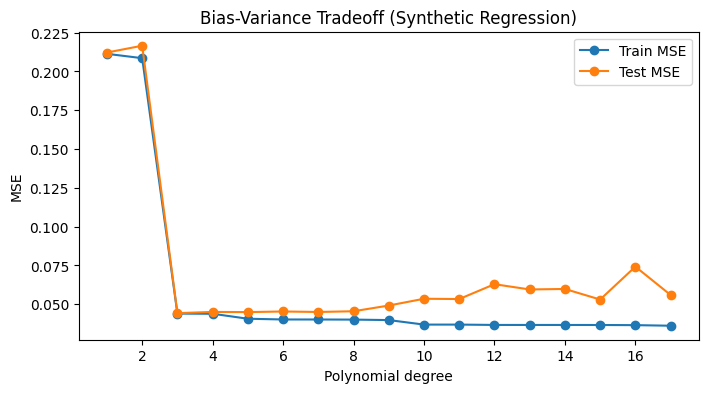

3

In [3]:
rng = np.random.default_rng(42)

n = 160
X = rng.uniform(0, 1, size=(n, 1))
noise_sigma = 0.2
y = np.sin(2 * np.pi * X[:, 0]) + rng.normal(0, noise_sigma, size=n)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

X_grid = np.linspace(0, 1, 400).reshape(-1, 1)
y_true = np.sin(2 * np.pi * X_grid[:, 0])

degrees = list(range(1, 18))
train_mse = []
test_mse = []

for d in degrees:
    model = Pipeline([
        ("poly", PolynomialFeatures(degree=d, include_bias=False)),
        ("lin", LinearRegression())
    ])
    model.fit(X_train, y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    train_mse.append(mean_squared_error(y_train, pred_train))
    test_mse.append(mean_squared_error(y_test, pred_test))

plt.figure(figsize=(8, 4))
plt.plot(degrees, train_mse, marker="o", label="Train MSE")
plt.plot(degrees, test_mse, marker="o", label="Test MSE")
plt.xlabel("Polynomial degree")
plt.ylabel("MSE")
plt.title("Bias-Variance Tradeoff (Synthetic Regression)")
plt.legend()
plt.show()

best_degree = degrees[int(np.argmin(test_mse))]
best_degree


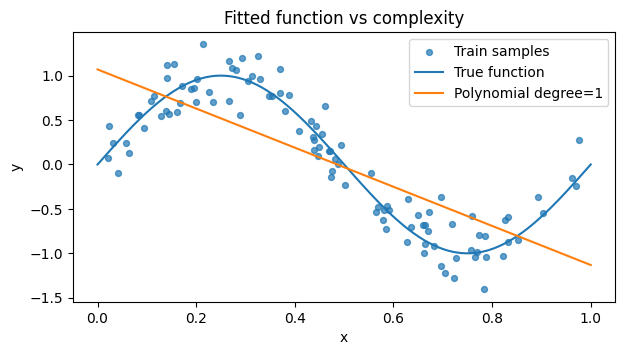

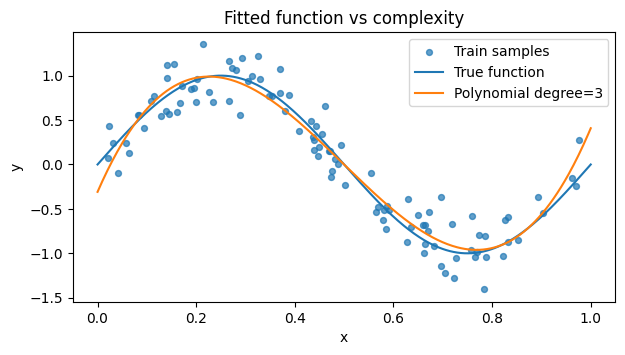

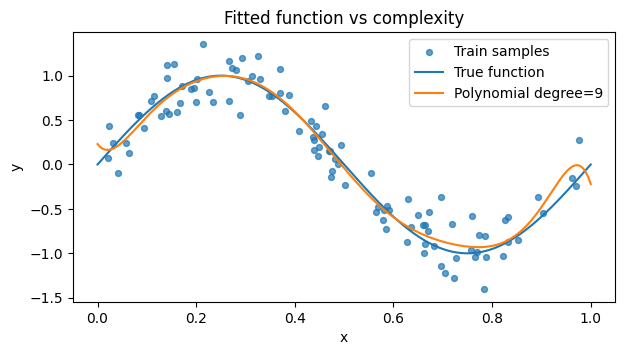

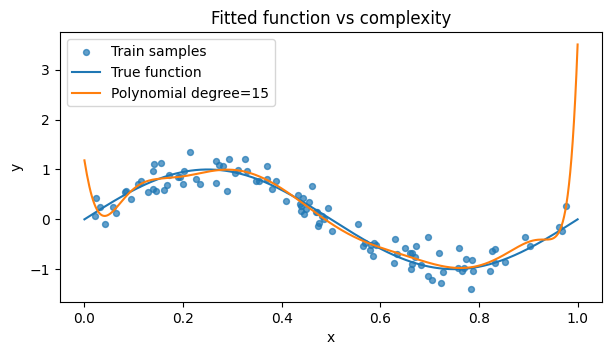

In [4]:
def fit_poly_and_predict(degree):
    model = Pipeline([
        ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
        ("lin", LinearRegression())
    ])
    model.fit(X_train, y_train)
    return model.predict(X_grid)

for d in [1, 3, 9, 15]:
    y_hat = fit_poly_and_predict(d)
    plt.figure(figsize=(7, 3.5))
    plt.scatter(X_train[:, 0], y_train, s=18, alpha=0.7, label="Train samples")
    plt.plot(X_grid[:, 0], y_true, label="True function")
    plt.plot(X_grid[:, 0], y_hat, label=f"Polynomial degree={d}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Fitted function vs complexity")
    plt.legend()
    plt.show()


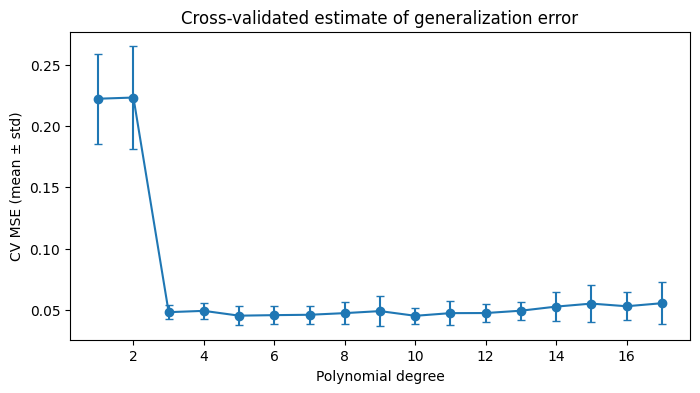

10

In [5]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_mse_mean = []
cv_mse_std = []

for d in degrees:
    model = Pipeline([
        ("poly", PolynomialFeatures(degree=d, include_bias=False)),
        ("lin", LinearRegression())
    ])
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="neg_mean_squared_error")
    mse_scores = -scores
    cv_mse_mean.append(mse_scores.mean())
    cv_mse_std.append(mse_scores.std())

plt.figure(figsize=(8, 4))
plt.errorbar(degrees, cv_mse_mean, yerr=cv_mse_std, marker="o", capsize=3)
plt.xlabel("Polynomial degree")
plt.ylabel("CV MSE (mean ± std)")
plt.title("Cross-validated estimate of generalization error")
plt.show()

degrees[int(np.argmin(cv_mse_mean))]



### بحث: چه چیزی باید ببینید؟

۱. **MSE آموزش** معمولاً با افزایش درجه کاهش می‌یابد. طبیعی است: کلاس مدل غنی‌تر بهتر روی دادهٔ آموزش می‌نشیند.  
۲. **MSE آزمون/اعتبارسنجی** اغلب ابتدا کاهش می‌یابد (کاهش بایاس) و سپس افزایش (غلبهٔ واریانس).  
۳. «بهترین» درجه به عوامل زیر وابسته است:
   - اندازهٔ نمونه $n$
   - سطح نویز $\sigma$
   - پیچیدگی تابع واقعی
   - پروتکل ارزیابی (یک برش ساده در برابر اعتبارسنجی متقاطع)

اگر نویز را زیاد کنید یا $n$ را کم کنید، اثر واریانس قوی‌تر می‌شود و درجهٔ بهینه معمولاً کوچک‌تر خواهد شد.

یک میان‌بُر ذهنی مفید:

- وقتی داده کم یا نویز زیاد است: مدل ساده‌تر یا منظم‌سازی قوی‌تر.
- وقتی داده زیاد و سیگنال قوی است: مدل منعطف‌تر معمولاً امن‌تر است.

---

## ۳. مشاهدهٔ مستقیم‌تر واریانس: شبیه‌سازی نمونه‌گیری تکراری

ترم واریانس دربارهٔ این است که مدل برازش‌شده در مجموعه‌داده‌های مختلف چقدر تغییر می‌کند. می‌توانیم آن را تقریب بزنیم با:

۱. ساخت چندین مجموعه‌دادهٔ آموزش مستقل از همان فرآیند،  
۲. برازش مدل در هر بار،  
۳. اندازه‌گیری تغییرپذیری پیش‌بینی‌ها روی یک شبکهٔ ثابت.

درجهٔ ۱ (کم‌پیچیدگی) را با درجهٔ ۱۵ (پرپیچیدگی) مقایسه می‌کنیم.

---


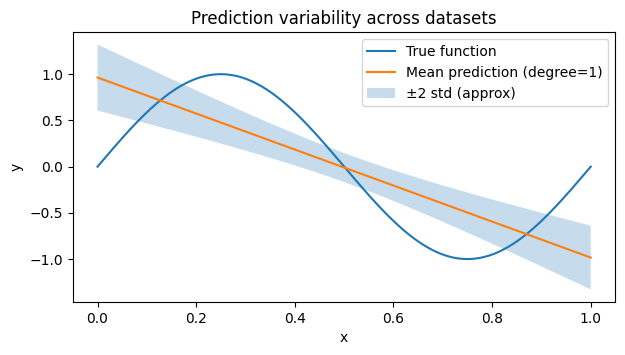

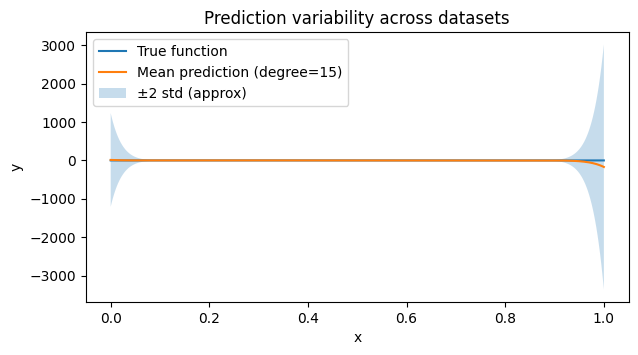

In [6]:
def simulate_predictions(degree, n_train=40, n_trials=200, sigma=0.25, seed=123):
    rng = np.random.default_rng(seed)
    preds = []
    for t in range(n_trials):
        X_t = rng.uniform(0, 1, size=(n_train, 1))
        y_t = np.sin(2 * np.pi * X_t[:, 0]) + rng.normal(0, sigma, size=n_train)
        model = Pipeline([
            ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
            ("lin", LinearRegression())
        ])
        model.fit(X_t, y_t)
        preds.append(model.predict(X_grid))
    return np.stack(preds, axis=0)

preds_deg1 = simulate_predictions(1)
preds_deg15 = simulate_predictions(15)

for deg, preds in [(1, preds_deg1), (15, preds_deg15)]:
    mean_pred = preds.mean(axis=0)
    std_pred = preds.std(axis=0)

    plt.figure(figsize=(7, 3.5))
    plt.plot(X_grid[:, 0], y_true, label="True function")
    plt.plot(X_grid[:, 0], mean_pred, label=f"Mean prediction (degree={deg})")
    plt.fill_between(X_grid[:, 0], mean_pred - 2*std_pred, mean_pred + 2*std_pred, alpha=0.25, label="±2 std (approx)")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Prediction variability across datasets")
    plt.legend()
    plt.show()



### تفسیر

- درجهٔ ۱: پیش‌بینی میانگین «پایدار» است (واریانس کم) اما در نواحی‌ای که تابع واقعی خمیده است به‌صورت سیستماتیک اشتباه می‌کند (بایاس).  
- درجهٔ ۱۵: میانگین پیش‌بینی ممکن است در برخی نقاط نزدیک‌تر باشد، اما تغییرپذیری پیش‌بینی‌ها زیاد است (واریانس زیاد). در نمونه‌های محدود، این ناپایداری معمولاً تعمیم‌پذیری را خراب می‌کند.

این همان بده‌بستان است: **به‌ندرت هدف این است که فقط بایاس یا فقط واریانس را کمینه کنید**. هدف، کمینه‌کردن خطای مورد انتظار روی دادهٔ جدید است.

---

## ۴. آزمایش طبقه‌بندی (دادهٔ واقعی): عمق و k به‌عنوان دکمه‌های پیچیدگی

برای طبقه‌بندی، از مجموعه‌دادهٔ Iris استفاده می‌کنیم (ساده، تمیز و به‌صورت CSV در مخزن شما موجود است). دو آزمایش کلاسیک انجام می‌دهیم:

۱. درخت تصمیم: افزایش `max_depth` پیچیدگی را بالا می‌برد.  
۲. kNN: **کوچک‌تر بودن** `k` پیچیدگی را بالا می‌برد (مرز تصمیم منعطف‌تر).

برای تخمین پایدارتر عملکرد، از اعتبارسنجی متقاطع استفاده می‌کنیم.

---


In [7]:
iris_path = Path("../../../Datasets/Classification/iris.csv")
if not iris_path.exists():
    raise FileNotFoundError(f"Dataset not found at: {iris_path.resolve()}")

iris = pd.read_csv(iris_path)
iris.head()


,sepal_length,sepal_width,petal_length,petal_width,classification
0,5.4,3.7,1.5,0.2,Iris-setosa
1,4.8,3.4,1.6,0.2,Iris-setosa
2,4.8,3.0,1.4,0.1,Iris-setosa
3,4.3,3.0,1.1,0.1,Iris-setosa
4,5.8,4.0,1.2,0.2,Iris-setosa


In [8]:
X_iris = iris.drop(columns=["classification"])
y_iris = iris["classification"]

X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(
    X_iris, y_iris, test_size=0.25, random_state=42, stratify=y_iris
)

cv = KFold(n_splits=5, shuffle=True, random_state=42)


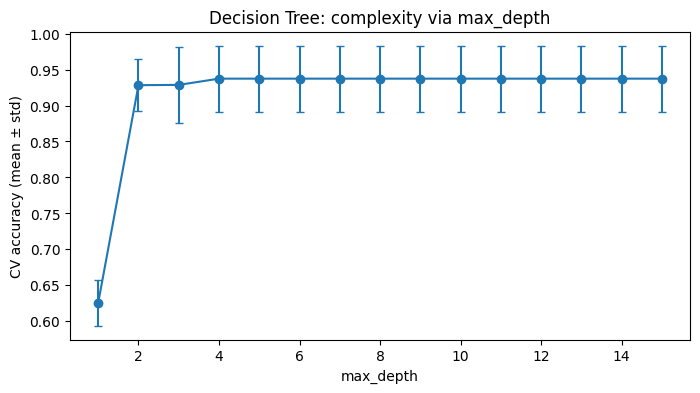

4

In [9]:
depths = list(range(1, 16))
cv_acc_mean = []
cv_acc_std = []

for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, random_state=42)
    scores = cross_val_score(clf, X_train_i, y_train_i, cv=cv, scoring="accuracy")
    cv_acc_mean.append(scores.mean())
    cv_acc_std.append(scores.std())

plt.figure(figsize=(8, 4))
plt.errorbar(depths, cv_acc_mean, yerr=cv_acc_std, marker="o", capsize=3)
plt.xlabel("max_depth")
plt.ylabel("CV accuracy (mean ± std)")
plt.title("Decision Tree: complexity via max_depth")
plt.show()

best_depth = depths[int(np.argmax(cv_acc_mean))]
best_depth


In [10]:
best_tree = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
best_tree.fit(X_train_i, y_train_i)

pred_train = best_tree.predict(X_train_i)
pred_test = best_tree.predict(X_test_i)

print("Train accuracy:", accuracy_score(y_train_i, pred_train))
print("Test  accuracy:", accuracy_score(y_test_i, pred_test))


Train accuracy: 0.9910714285714286
Test  accuracy: 0.9210526315789473


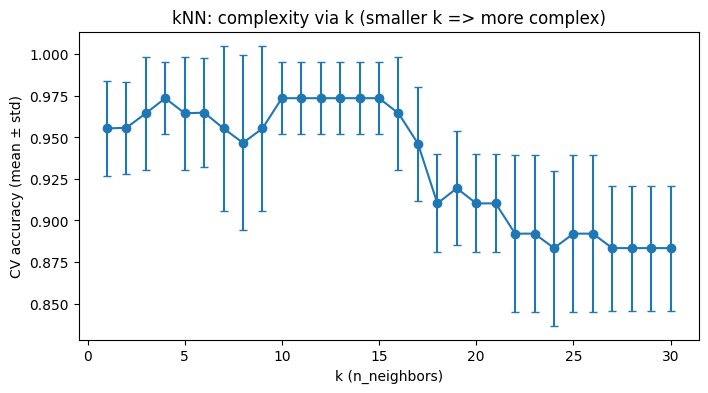

4

In [11]:
k_values = list(range(1, 31))
knn_cv_mean = []
knn_cv_std = []

for k in k_values:
    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=k))
    ])
    scores = cross_val_score(clf, X_train_i, y_train_i, cv=cv, scoring="accuracy")
    knn_cv_mean.append(scores.mean())
    knn_cv_std.append(scores.std())

plt.figure(figsize=(8, 4))
plt.errorbar(k_values, knn_cv_mean, yerr=knn_cv_std, marker="o", capsize=3)
plt.xlabel("k (n_neighbors)")
plt.ylabel("CV accuracy (mean ± std)")
plt.title("kNN: complexity via k (smaller k => more complex)")
plt.show()

best_k = k_values[int(np.argmax(knn_cv_mean))]
best_k


In [12]:
best_knn = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=best_k))
])
best_knn.fit(X_train_i, y_train_i)

pred_train = best_knn.predict(X_train_i)
pred_test = best_knn.predict(X_test_i)

print("Train accuracy:", accuracy_score(y_train_i, pred_train))
print("Test  accuracy:", accuracy_score(y_test_i, pred_test))


Train accuracy: 0.9642857142857143
Test  accuracy: 0.9210526315789473



### بحث: شهود بایاس/واریانس در طبقه‌بندی

- عمق درخت تصمیم:
  - عمق کم: تقسیم‌بندی ساده → بایاس بیشتر، واریانس کمتر.
  - عمق زیاد: تقسیم‌بندی زیاد → بایاس کمتر، واریانس بیشتر.

- kNN:
  - `k` کوچک (مثلاً ۱): طبقه‌بند نسبت به نقاط نزدیک بسیار واکنشی است → واریانس زیاد.
  - `k` بزرگ: مرز تصمیم هموارتر → بایاس بیشتر، واریانس کمتر.

در هر دو حالت، اعتبارسنجی متقاطع کمک می‌کند سطح پیچیدگی مناسب را بدون دست‌زدن به مجموعهٔ آزمون انتخاب کنید.

---



## ۴.۱ منظم‌سازی به‌عنوان کنترل پیچیدگی (طبقه‌بندی): Logistic Regression روی diabetes.csv

رگرسیون لجستیک یک طبقه‌بند خطی است، اما **پیچیدگی مؤثر** آن به منظم‌سازی وابستگی زیادی دارد.

با منظم‌سازی L2، یک تابع هدف رایج (در حالت دودویی) این است:

$$
\min_{w,b}\;\; \sum_{i=1}^{n} \log\left(1 + \exp\left(-y_i (w^\top x_i + b)\right)\right) + \lambda \|w\|_2^2
$$

در scikit‑learn، ابرپارامتر `C` معکوسِ شدت منظم‌سازی است: $C = 1/\lambda$.
پس:

- `C` بزرگ → منظم‌سازی ضعیف → ریسک واریانس بیشتر
- `C` کوچک → منظم‌سازی قوی → ریسک بایاس بیشتر

`C` را جاروب می‌کنیم و با Cross‑Validation مقدار مناسب را انتخاب می‌کنیم.

---


In [13]:
db_path = Path("../../../Datasets/Classification/diabetes.csv")
if not db_path.exists():
    raise FileNotFoundError(f"Dataset not found at: {db_path.resolve()}")

db = pd.read_csv(db_path)
db.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,classification
0,6,148,72,35,0,33.6,0.627,50,Diabetic
1,1,85,66,29,0,26.6,0.351,31,Non-Diabetic
2,8,183,64,0,0,23.3,0.672,32,Diabetic
3,1,89,66,23,94,28.1,0.167,21,Non-Diabetic
4,0,137,40,35,168,43.1,2.288,33,Diabetic


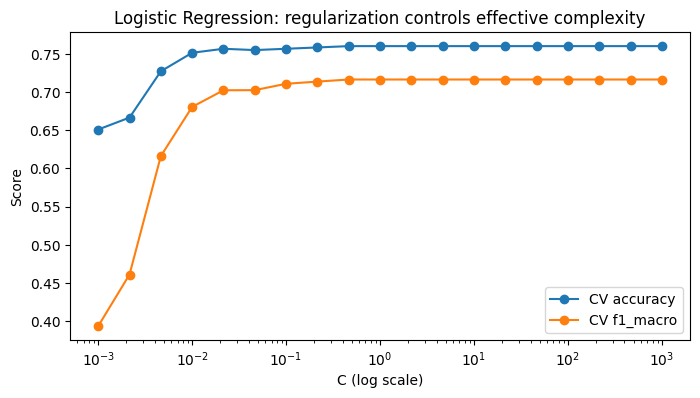

np.float64(0.46415888336127775)

In [14]:
X_db = db.drop(columns=["classification"])
y_db = db["classification"]

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(
    X_db, y_db, test_size=0.25, random_state=42, stratify=y_db
)

cv = KFold(n_splits=5, shuffle=True, random_state=42)

Cs = np.logspace(-3, 3, 19)
cv_acc = []
cv_f1 = []

for C in Cs:
    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(C=C, max_iter=5000, solver="lbfgs"))
    ])
    acc_scores = cross_val_score(clf, X_train_d, y_train_d, cv=cv, scoring="accuracy")
    f1_scores = cross_val_score(clf, X_train_d, y_train_d, cv=cv, scoring="f1_macro")
    cv_acc.append(acc_scores.mean())
    cv_f1.append(f1_scores.mean())

plt.figure(figsize=(8, 4))
plt.semilogx(Cs, cv_acc, marker="o", label="CV accuracy")
plt.semilogx(Cs, cv_f1, marker="o", label="CV f1_macro")
plt.xlabel("C (log scale)")
plt.ylabel("Score")
plt.title("Logistic Regression: regularization controls effective complexity")
plt.legend()
plt.show()

best_C = Cs[int(np.argmax(cv_f1))]
best_C


In [15]:
best_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(C=best_C, max_iter=5000, solver="lbfgs"))
])
best_lr.fit(X_train_d, y_train_d)

pred_train = best_lr.predict(X_train_d)
pred_test = best_lr.predict(X_test_d)

print("Best C:", best_C)
print("Train accuracy:", accuracy_score(y_train_d, pred_train))
print("Test  accuracy:", accuracy_score(y_test_d, pred_test))
print("Train f1_macro:", f1_score(y_train_d, pred_train, average="macro"))
print("Test  f1_macro:", f1_score(y_test_d, pred_test, average="macro"))


Best C: 0.46415888336127775
Train accuracy: 0.7777777777777778
Test  accuracy: 0.7864583333333334
Train f1_macro: 0.7398227090508723
Test  f1_macro: 0.7526317443358577



## ۵. مدیریت بده‌بستان روی یک مجموعه‌دادهٔ رگرسیونی واقعی (cognitive.csv)

اکنون از یک دادهٔ جدولی واقعی در مخزن شما استفاده می‌کنیم: **cognitive.csv**. هدف، پیش‌بینی `kid_score` است و بررسی می‌کنیم چگونه منظم‌سازی پیچیدگی را کنترل می‌کند.

مقایسه می‌کنیم:

- رگرسیون خطی (بدون منظم‌سازی)
- رگرسیون Ridge (منظم‌سازی L2): با افزایش $\alpha$، پیچیدگی کاهش می‌یابد

برای Ridge، تابع هدف چنین است:

$$
\min_{w} \sum_{i=1}^{n} (y_i - x_i^\top w)^2 + \alpha \|w\|_2^2
$$

با بزرگ شدن $\alpha$، ضرایب کوچک می‌شوند و مدل نسبت به نویز نمونه‌گیری حساسیت کمتری پیدا می‌کند (کاهش واریانس)، معمولاً به قیمت افزایش مقداری بایاس.

---


In [16]:
cog_path = Path("../../../Datasets/Regression/cognitive.csv")
if not cog_path.exists():
    raise FileNotFoundError(f"Dataset not found at: {cog_path.resolve()}")

cog = pd.read_csv(cog_path)
cog.head()


,kid_score,mom_hs,mom_iq,mom_work,mom_age
0,65,yes,121.117529,yes,27
1,98,yes,89.361882,yes,25
2,85,yes,115.443165,yes,27
3,83,yes,99.449639,yes,25
4,115,yes,92.745710,yes,27


In [17]:
target = "kid_score"
X = cog.drop(columns=[target])
y = cog[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

categorical_cols = [c for c in X.columns if X[c].dtype == "object"]
numeric_cols = [c for c in X.columns if X[c].dtype != "object"]

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, numeric_cols),
    ("cat", categorical_pipe, categorical_cols)
])


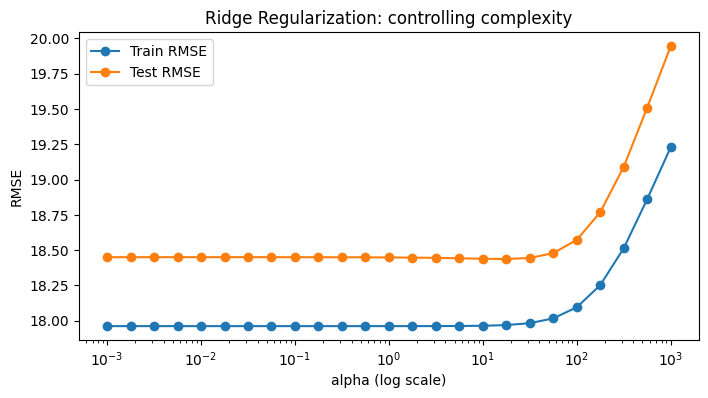

np.float64(17.78279410038923)

In [18]:
alphas = np.logspace(-3, 3, 25)

train_rmse = []
test_rmse = []

for a in alphas:
    model = Pipeline([
        ("prep", preprocess),
        ("ridge", Ridge(alpha=a, random_state=42))
    ])
    model.fit(X_train, y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    train_rmse.append(np.sqrt(mean_squared_error(y_train, pred_train)))
    test_rmse.append(np.sqrt(mean_squared_error(y_test, pred_test)))

plt.figure(figsize=(8, 4))
plt.semilogx(alphas, train_rmse, marker="o", label="Train RMSE")
plt.semilogx(alphas, test_rmse, marker="o", label="Test RMSE")
plt.xlabel("alpha (log scale)")
plt.ylabel("RMSE")
plt.title("Ridge Regularization: controlling complexity")
plt.legend()
plt.show()

alphas[int(np.argmin(test_rmse))]


In [19]:
best_alpha = alphas[int(np.argmin(test_rmse))]

best_ridge = Pipeline([
    ("prep", preprocess),
    ("ridge", Ridge(alpha=best_alpha, random_state=42))
])
best_ridge.fit(X_train, y_train)

pred_test = best_ridge.predict(X_test)
print("Best alpha:", best_alpha)
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, pred_test)))
print("Test R^2:", r2_score(y_test, pred_test))


Best alpha: 17.78279410038923
Test RMSE: 18.43694453559538
Test R^2: 0.23133105067964777



## ۶. منحنی‌های یادگیری: عیب‌یابی بایاس در برابر واریانس به‌صورت سیستماتیک

منحنی یادگیری عملکرد مدل را بر حسب اندازهٔ دادهٔ آموزش نشان می‌دهد و یک ابزار عیب‌یابی بسیار عملی است:

- اگر خطای آموزش و اعتبارسنجی هر دو زیاد باشند و به مقدار مشابهی همگرا شوند → **بایاس زیاد**.
- اگر خطای آموزش کم اما خطای اعتبارسنجی زیاد باشد (شکاف بزرگ) → **واریانس زیاد**.
- اگر هر دو کم و نزدیک باشند → تعادل مناسب.

برای نمونه، منحنی یادگیری را برای:

- یک درخت رگرسیون کم‌عمق (ساده‌تر)
- یک درخت رگرسیون پرعمق (پیچیده‌تر)

حساب می‌کنیم. برای یکپارچگی، همان دادهٔ رگرسیونی (cognitive.csv) را استفاده می‌کنیم.

---


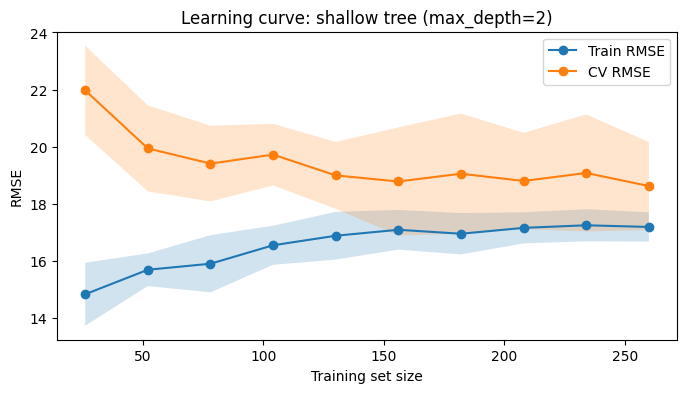

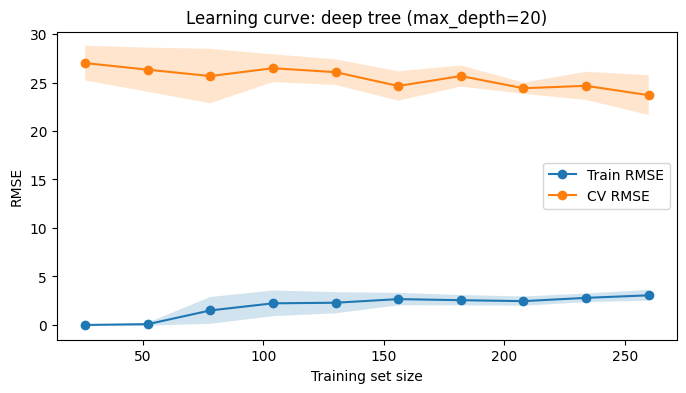

In [20]:
def plot_learning_curve(estimator, X, y, title, cv):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=cv, scoring="neg_root_mean_squared_error",
        train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, random_state=42
    )
    train_mean = -train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = -val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)

    plt.figure(figsize=(8, 4))
    plt.plot(train_sizes, train_mean, marker="o", label="Train RMSE")
    plt.plot(train_sizes, val_mean, marker="o", label="CV RMSE")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)
    plt.xlabel("Training set size")
    plt.ylabel("RMSE")
    plt.title(title)
    plt.legend()
    plt.show()

tree_shallow = Pipeline([
    ("prep", preprocess),
    ("tree", DecisionTreeRegressor(max_depth=2, random_state=42))
])

tree_deep = Pipeline([
    ("prep", preprocess),
    ("tree", DecisionTreeRegressor(max_depth=20, random_state=42))
])

plot_learning_curve(tree_shallow, X_train, y_train, "Learning curve: shallow tree (max_depth=2)", cv=cv)
plot_learning_curve(tree_deep, X_train, y_train, "Learning curve: deep tree (max_depth=20)", cv=cv)



### چک‌لیست عیب‌یابی عملی

وقتی **بایاس زیاد (Underfitting)** می‌بینید:

- به سراغ کلاس مدل بیانگرتر بروید (ویژگی‌های غیرخطی، درخت‌ها، کرنل‌ها).
- منظم‌سازی را کمتر کنید (مثلاً $\alpha$ کوچک‌تر در Ridge/Lasso و `C` بزرگ‌تر در لجستیک).
- ویژگی‌های اطلاعاتی اضافه کنید؛ مهندسی ویژگی را بهبود دهید.
- برای مدل‌های تکراری بیشتر آموزش دهید یا محدودیت‌ها را کم کنید (مثلاً عمق درخت را بیشتر کنید).

وقتی **واریانس زیاد (Overfitting)** می‌بینید:

- منظم‌سازی را بیشتر کنید (مثلاً $\alpha$ بزرگ‌تر و `C` کوچک‌تر).
- ظرفیت مدل را کم کنید (درجهٔ کمتر، درخت کم‌عمق‌تر، k بزرگ‌تر در kNN).
- دادهٔ بیشتر جمع کنید (اغلب مؤثرترین راه کاهش واریانس).
- از Ensembling (مثل Bagging/Random Forest) برای پایدارکردن یادگیرنده‌های پر واریانس استفاده کنید.
- پروتکل اعتبارسنجی را اصلاح کنید (Cross‑Validation؛ جلوگیری از Leakage).

یک روند منظم این است: **(۱) پروتکل ارزیابی را تعریف کنید**، **(۲) پیچیدگی را با اعتبارسنجی انتخاب کنید**، **(۳) مدل را قفل کنید**، **(۴) فقط یک بار روی تست ارزیابی کنید**.

---



## ۷. اختیاری: کاهش واریانس با Random Forest (نمایش سریع)

درخت تصمیم معمولاً یادگیرنده‌ای با واریانس بالا است. Random Forest یک تکنیک کاهش واریانس است که میانگینِ چندین درخت آموزش‌دیده روی نمونه‌های بوت‌استرپ را با انتخاب تصادفی ویژگی‌ها می‌گیرد.

حتی روی دادهٔ تمیزی مثل Iris ممکن است ببینید که Random Forest:

- نسبت به انتخاب عمق/ساختار حساسیت کمتری دارد
- اغلب در عملکرد آزمون رقابتی یا بهتر است

این «جادو» نیست: میانگین‌گیری وقتی مدل‌های پایه کاملاً همبسته نباشند، واریانس را کاهش می‌دهد.

---


In [21]:
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf_scores = cross_val_score(rf, X_train_i, y_train_i, cv=cv, scoring="accuracy")
print("Random Forest CV accuracy (mean ± std):", rf_scores.mean(), "±", rf_scores.std())

rf.fit(X_train_i, y_train_i)
print("Random Forest test accuracy:", rf.score(X_test_i, y_test_i))


Random Forest CV accuracy (mean ± std): 0.9470355731225297 ± 0.05126773238605839
Random Forest test accuracy: 0.8947368421052632



## ۸. نکتهٔ پیشرفته: «Double Descent» و اینکه چرا اعتبارسنجی همچنان تعیین‌کننده است

در بسیاری از مسائل کلاسیک، خطای آزمون بر حسب پیچیدگی شبیه یک U است. اما در مدل‌های بسیار پرظرفیتِ مدرن، پدیده‌ای به نام **Double Descent** دیده می‌شود:

- خطا کاهش می‌یابد (کاهش بایاس)
- نزدیک «آستانهٔ اینترپولیشن» افزایش می‌یابد (جهش واریانس)
- سپس با بیش‌پارامتری‌شدن زیاد (و نوعی منظم‌سازی/آموزش ضمنی) دوباره کاهش می‌یابد

برای استفادهٔ عملی از بده‌بستان، دانستن این پدیده ضروری نیست. قانون عملی تغییر نمی‌کند:

- یک پروتکل اعتبارسنجی تعریف کنید
- پیچیدگی را روی اعتبارسنجی تنظیم کنید
- فقط یک بار روی تست نهایی ارزیابی کنید

اگر شک دارید، به منحنی تجربی حاصل از Cross‑Validation اعتماد کنید، نه فقط به یک تصویر نظری.

---



## ۹. جمع‌بندی

اکنون باید با نکات زیر راحت باشید:

۱. **بایاس** خطای سیستماتیک ناشی از فرض‌های محدودکننده است و با افزایش پیچیدگی کاهش می‌یابد.  
۲. **واریانس** حساسیت به نویز نمونه‌گیری است و با افزایش پیچیدگی افزایش می‌یابد.  
۳. **نویز** با همین ویژگی‌ها و فرآیند اندازه‌گیری کاهش‌ناپذیر است.  
۴. خطای آموزش معمولاً با پیچیدگی کاهش می‌یابد، اما خطای اعتبارسنجی/آزمون اغلب شکل U دارد.  
۵. پیچیدگی درست با **اعتبارسنجی** (معمولاً Cross‑Validation) انتخاب می‌شود، نه با نگاه کردن به نتایج تست.  
۶. منظم‌سازی، هرس‌کردن، توقف زودهنگام و Ensembling ابزارهای عملی کنترل پیچیدگی هستند.

---

## تمرین‌ها (برای تسلط واقعی انجام دهید)

۱. **آزمون فشار رگرسیون چندجمله‌ای**  
   در آزمایش مصنوعی، این موارد را تغییر دهید:
   - `n` (تعداد نقاط آموزش)
   - `noise_sigma`
   - تابع واقعی (مثلاً فرکانس‌های بالاتر اضافه کنید)
   گزارش کنید درجهٔ بهینه چگونه تغییر می‌کند و چرا.

۲. **تخمین واریانس با بوت‌استرپ**  
   روی دادهٔ مصنوعی، مجموعهٔ آموزش را ۲۰۰ بار بوت‌استرپ کنید و انحراف معیار پیش‌بینی را در $x=0.25$, $0.50$, و $0.75$ برای درجات ۳ و ۱۵ محاسبه کنید.

۳. **عمق در برابر هرس‌کردن**  
   روی Iris مقایسه کنید:
   - درخت عمیق با `max_depth=None`
   - درخت هرس‌شده با `min_samples_leaf` و `ccp_alpha`
   از Cross‑Validation استفاده کنید و گزارش دهید کدام پایدارتر است.

۴. **Ridge در برابر رگرسیون خطی**  
   روی cognitive.csv، رگرسیون خطی و Ridge را در چندین برش تصادفی آموزش/آزمون مقایسه کنید و تغییرپذیری RMSE تست را خلاصه کنید.

۵. **بررسی تفسیر**  
   با زبان خودتان توضیح دهید چرا «دادهٔ بیشتر» اغلب بهترین درمان واریانس زیاد است، اما لزوماً برای بایاس زیاد کافی نیست.

---

### ارتباط با درس‌های بعدی

بده‌بستان بایاس–واریانس ستون فقرات مفهومی موضوعات بعدی است:
- Ensembleها (Bagging واریانس را کم می‌کند، Boosting می‌تواند بایاس را کاهش دهد)
- انتخاب مدل و Cross‑Validation
- منظم‌سازی و پایداری

اکنون آماده‌اید این اصول را در مدل‌های پیشرفته‌تر به‌صورت منظم به‌کار بگیرید.
